# 1.資料探索與前處理

### 資料讀取

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent.parent
print("專案根目錄:", PROJECT_ROOT)
DATA_PATH = PROJECT_ROOT / "dataset" / "steel" / "steel_faults.csv"
# 讀取資料
df = pd.read_csv(DATA_PATH)
print("資料維度:", df.shape)
df.head()


專案根目錄: /Users/ching/Documents/SideProject/industrial-fault-prediction
資料維度: (1941, 34)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


### 欄位處理

In [7]:

# 最後七欄為瑕疵標籤（每一欄代表一種瑕疵）
label_cols = df.columns[-7:]
df['fault_type'] = df[label_cols].idxmax(axis=1)  # 多類瑕疵合併成單一欄位

# 刪除原來的多標籤欄
df = df.drop(columns=label_cols)


## 資料分割

In [8]:

from sklearn.model_selection import train_test_split

X = df.drop(columns=["fault_type"])
y = df["fault_type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X.shape


(1941, 27)

## 異常值處理（Outlier Handling）
	•	繪製每個數值欄位的箱型圖（boxplot）查看極端值
	•	可使用 IQR 或標準差方法對極端值進行裁切或填補

/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27396 (\N{CJK UNIFIED IDEOGRAPH-6B04}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fig

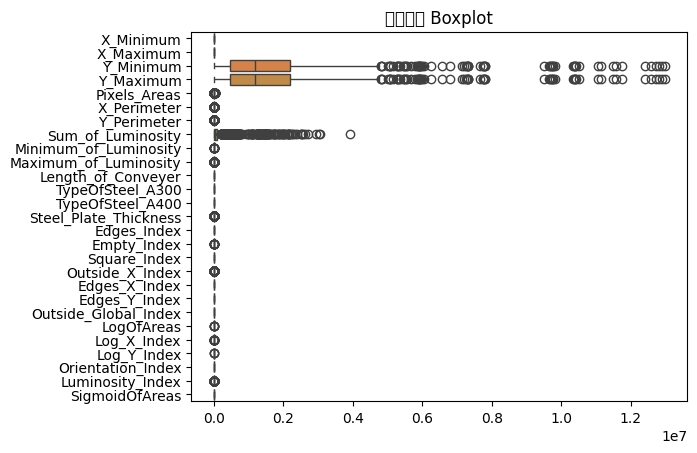

In [108]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
sns.boxplot(data=X_train[numeric_cols], orient='h')
plt.title("數值欄位 Boxplot")
plt.show()

### 使用 IQR 裁切極端值

In [109]:
def get_iqr_bounds(df, columns):
    bounds = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        bounds[col] = (lower, upper)
    return bounds

def apply_iqr_clip(df, bounds):
    df_clipped = df.copy()
    for col, (lower, upper) in bounds.items():
        df_clipped[col] = df[col].clip(lower, upper)
    return df_clipped



# 1. 根據訓練資料建立 IQR 上下限
iqr_bounds = get_iqr_bounds(X_train, numeric_cols)

# 2. 應用到訓練與測試資料
X_train_clipped = apply_iqr_clip(X_train, iqr_bounds)
X_test_clipped = apply_iqr_clip(X_test, iqr_bounds)


### 使用標準差（Z-score）裁切異常值

In [110]:
def clip_outliers_std(df, columns, z_thresh=3):
    df_clipped = df.copy()
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        lower = mean - z_thresh * std
        upper = mean + z_thresh * std
        df_clipped[col] = df[col].clip(lower, upper)
    return df_clipped

# df_clipped_std = clip_outliers_std(X_train, numeric_cols)

#### 🔍 方法比較：IQR vs Z-score

| 項目                     | IQR（四分位距）法                              | Z-score（標準差）法                          |
|--------------------------|------------------------------------------------|---------------------------------------------|
| 📏 原理                  | 根據資料的中位數與四分位距（Q1, Q3）計算     | 根據平均值與標準差計算                      |
| 📊 對分布的假設          | **非常態分布也適用**                          | 假設資料服從**常態分布（Gaussian）**        |
| 📉 敏感度                | **對極端值較不敏感**（使用中位數計算）        | 對極端值較敏感（平均數與標準差會被拉高）     |
| 🧪 應用範圍              | 適合偏態分布、不對稱資料                      | 適合對稱、近似常態分布的資料                |
| ✅ 使用情境              | 生產資料、財務資料等易偏態或異常值的數據集   | 感測器數據、測試成績等常態分布資料          |
| 📦 實作方式              | 建議使用「裁切」以保留樣本                    | 可「裁切」或「刪除」異常值                   |
| 📉 舉例限制              | 無法識別輕微離群值                            | 過於敏感，可能誤殺非異常值                   |

#### ✅ 建議使用時機

| 你的資料情況                     | 建議方法             | 原因 |
|----------------------------------|----------------------|------|
| 分布明顯偏斜、有極端離群值       | **IQR**              | 使用中位數與 IQR 不易受極端值影響 |
| 分布近似常態、數值範圍穩定       | **Z-score**          | 適合統計分析與標準化評估           |
| 資料量很小，不希望刪除資料       | **Clip 而非 Drop**   | 使用 clip 裁切數值範圍可保留資料  |
| 模型為樹類模型（RF、XGB）        | **可不做 Outlier 處理** | 這類模型對極端值不太敏感         |
| 模型為 SVM、LogReg、KNN、NN      | **需要處理 Outlier** | 這些模型對極端值敏感             |

## 標準化與縮放（Scaling）

In [111]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clipped)
X_test_scaled = scaler.transform(X_test_clipped)


## 類別重新編碼（Label Encoding）

In [112]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## 特徵選擇與降維與欄位分布視覺化（EDA）

### 瑕疵類型分布（類別是否嚴重不平衡）

/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27171 (\N{CJK UNIFIED IDEOGRAPH-6A23}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29781 (\N{CJK UNIFIED IDEOGRAPH-7455}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fig

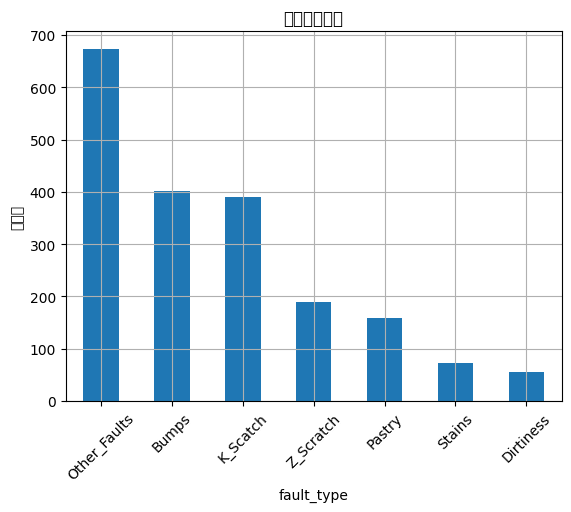

In [113]:
# 查看瑕疵類型分布
df['fault_type'].value_counts().plot(kind='bar', title="瑕疵類別分布")
plt.ylabel("樣本數")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### heatmap（特徵間相關性）

/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_8515/572127616.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_8515/572127616.py:22: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_8515/572127616.py:22: UserWarning: Glyph 24501 (\N{CJK UNIFIED IDEOGRAPH-5FB5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_8515/572127616.py:22: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zc/bg3g21_j7yq8y2dpzx88kk4w0000gn/T/ipykernel_8515/572127616.py:22: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zc/bg3g21_j7yq8y2d

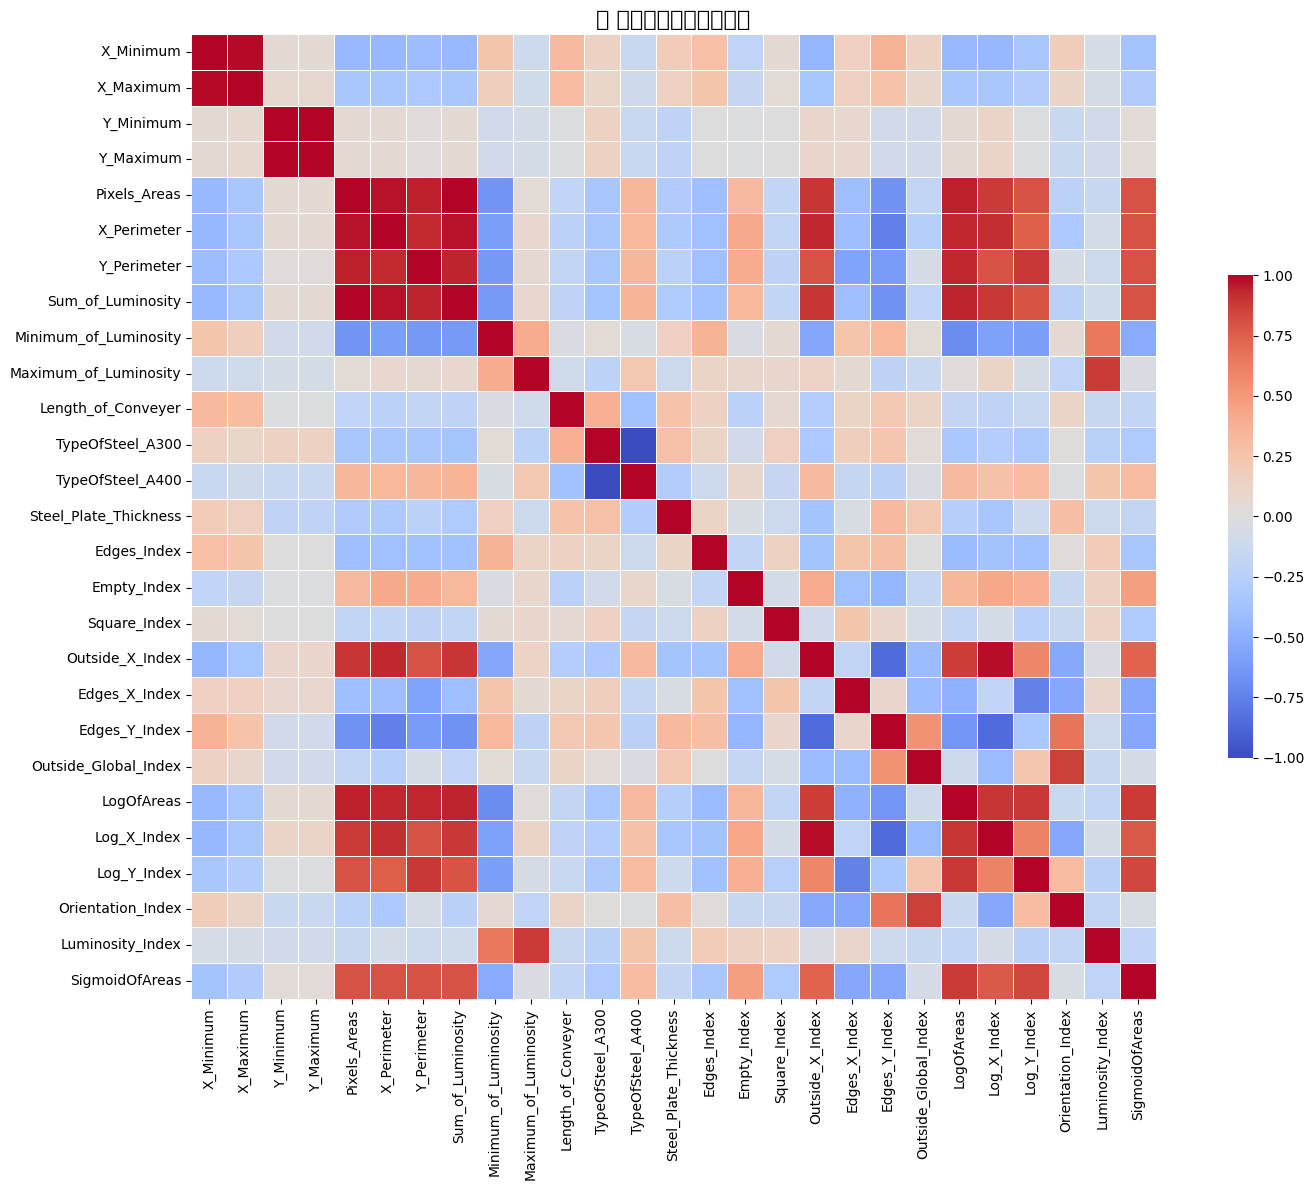

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 若是標準化後的 DataFrame（例如 X_train_scaled_df）
corr_matrix = X_train_scaled_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, 
            cmap='coolwarm', 
            annot=False, 
            fmt=".2f", 
            square=True, 
            cbar_kws={'shrink': .5},
            linewidths=0.5)

plt.title("📈 特徵間相關係數熱力圖", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [115]:
def remove_high_corr_features(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    return df.drop(columns=to_drop), to_drop



# 在訓練資料上刪除高相關特徵
X_train_reduced, dropped_features = remove_high_corr_features(X_train_scaled_df)

# 在測試資料上刪除相同欄位
X_test_reduced = X_test_scaled_df.drop(columns=dropped_features)

print("刪除的高相關特徵:", dropped_features)
X_test_reduced.shape


刪除的高相關特徵: ['X_Maximum', 'Y_Maximum', 'X_Perimeter', 'Sum_of_Luminosity', 'TypeOfSteel_A400', 'Log_X_Index']


(389, 21)

Text(0.5, 1.0, '📈 刪除高相關特徵後的相關係數熱力圖')

/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 21034 (\N{CJK UNIFIED IDEOGRAPH-522A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 38500 (\N{CJK UNIFIED IDEOGRAPH-9664}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.1

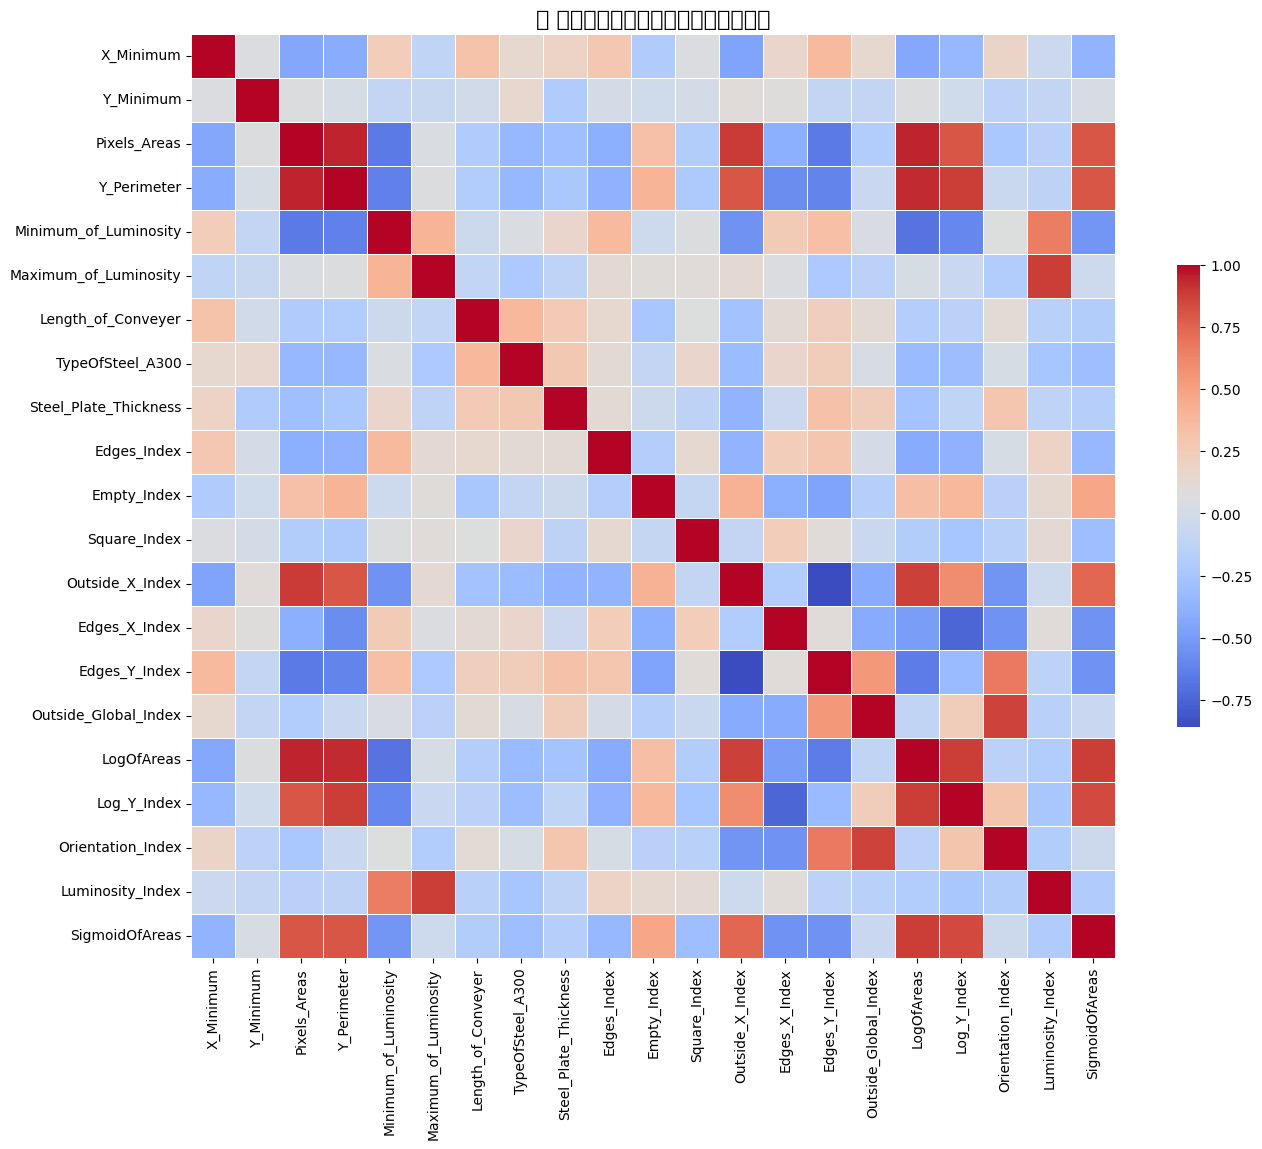

In [116]:
# 檢查刪除後的相關係數矩陣
corr_matrix_reduced = X_train_reduced.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_reduced, 
            cmap='coolwarm', 
            annot=False, 
            fmt=".2f", 
            square=True, 
            cbar_kws={'shrink': .5},
            linewidths=0.5)
plt.title("📈 刪除高相關特徵後的相關係數熱力圖", fontsize=16)

## 類別分佈檢查與處理不平衡
	•	顯示每類樣本數，若嚴重不平衡可使用 SMOTE、SMOTEENN、ClassWeight 等方法

In [117]:

from imblearn.combine import SMOTEENN

# SMOTEENN 重抽樣
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_reduced, y_train_enc)

X_resampled.shape


(3113, 21)

### SMOTEENN後類別分佈檢查

['Bumps' 'Dirtiness' 'K_Scatch' 'Other_Faults' 'Pastry' 'Stains'
 'Z_Scratch']


/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27171 (\N{CJK UNIFIED IDEOGRAPH-6A23}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ching/.pyenv/versions/3.10.13/envs/cv-auto-label-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24460 (\N{CJK UNIFIED IDEOGRAPH-5F8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fig

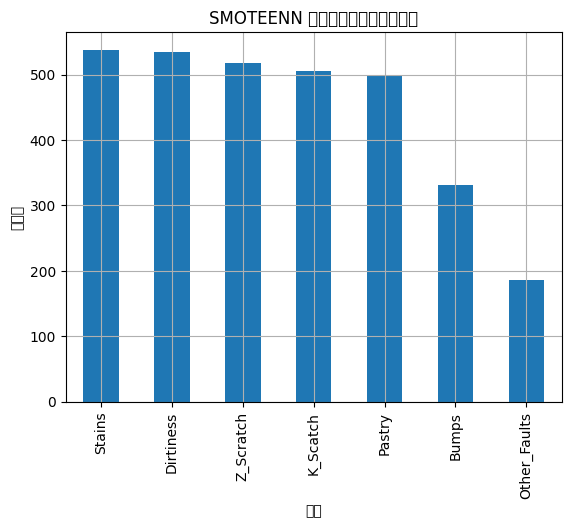

In [118]:

# 將數值轉回原本的類別名稱
y_labels = le.inverse_transform([0, 1, 2, 3, 4, 5, 6])  # 你可以換成任何 array
print(y_labels)
# 將 y_resampled 的類別編碼轉成文字
y_resampled_labels = le.inverse_transform(y_resampled)
pd.Series(y_resampled_labels).value_counts().plot(kind='bar', title="SMOTEENN 後的類別分佈（文字版）")
plt.xlabel("類別")
plt.ylabel("樣本數")
plt.grid(True)
plt.show()